- # Predicción de genes en genomas bacterianos.
- # Búsqueda de secuencias proteícas en bases de datos.
- # Búsqueda de secuencias homólogas usando BLAST.
- # Búsqueda de dominios funcionales en proteinas seleccionadas.

# Preparación del entorno

Para que el notebook funcione adecuadamente debemos llenar el archivo credentials.py con un correo electrónico y la API key que proporciona NCBI a sus usuarios registrados.

Con el siguiente código cargamos las bibliotecas necesarias para que todo el código del notebook funcione.

Para ello se requiere de la instalación de los siguientes paquetes:

- **Pandas** para manejo general de datos 
- **pyCirclize** para visualizar nuestros datos genómicos
- **pyrodigal** para la predicción de genes codificantes
- **requests** para interactuar con las APIs de NCBI, UniProt e InterProScan
- **seaborn** para visualizar algunas de las propiedades genómicas obtenidas
- **subprocess** ejecutar comandos fuera del entorno de python
- **BioPython** para el manejo de secuencias
- **io** para conectar las entradas y salidas de los distintos programas

Además de la instalación local de BLAST+, se puede obtener mayor información a tráves del siguiente link: https://www.ncbi.nlm.nih.gov/books/NBK569861/ y el paquete a descargar de acuerdo a su sistemas operativo aqui ftp://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/

Para la instalación de las bibliotecas mencionadas puede ejecutar los siguientes comandos:

In [1]:
! wget https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.17.0+-x64-linux.tar.gz

--2026-02-20 15:46:27--  https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.17.0+-x64-linux.tar.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296006458 (282M) [application/x-gzip]
Saving to: ‘ncbi-blast-2.17.0+-x64-linux.tar.gz.1’

ncbi-blast-2.17.0+- 100%[===================>] 282.29M  18.5MB/s    in 25s     

2026-02-20 15:46:51 (11.5 MB/s) - ‘ncbi-blast-2.17.0+-x64-linux.tar.gz.1’ saved [296006458/296006458]



In [2]:
! tar -zxf ncbi-blast-2.17.0+-x64-linux.tar.gz

In [3]:
! ./ncbi-blast-2.17.0+/bin/blastp -help

USAGE
  blastp [-h] [-help] [-import_search_strategy filename]
    [-export_search_strategy filename] [-task task_name] [-db database_name]
    [-dbsize num_letters] [-gilist filename] [-seqidlist filename]
    [-negative_gilist filename] [-negative_seqidlist filename]
    [-taxids taxids] [-negative_taxids taxids] [-taxidlist filename]
    [-negative_taxidlist filename] [-no_taxid_expansion] [-ipglist filename]
    [-negative_ipglist filename] [-entrez_query entrez_query]
    [-db_soft_mask filtering_algorithm] [-db_hard_mask filtering_algorithm]
    [-subject subject_input_file] [-subject_loc range] [-query input_file]
    [-out output_file] [-evalue evalue] [-word_size int_value]
    [-gapopen open_penalty] [-gapextend extend_penalty]
    [-qcov_hsp_perc float_value] [-max_hsps int_value]
    [-xdrop_ungap float_value] [-xdrop_gap float_value]
    [-xdrop_gap_final float_value] [-searchsp int_value] [-seg SEG_options]
    [-soft_masking soft_masking] [-matrix matrix_name]
    [-thre

In [4]:
! wget https://github.com/vflorelo/

--2026-02-20 15:47:00--  https://github.com/vflorelo/
Resolving github.com (github.com)... 20.26.156.215
Connecting to github.com (github.com)|20.26.156.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html.1’

index.html.1            [ <=>                ] 199.59K  --.-KB/s    in 0.02s   

2026-02-20 15:47:01 (9.00 MB/s) - ‘index.html.1’ saved [204380]



In [5]:
%pip install matplotlib
%pip install pandas
%pip install pycirclize
%pip install pyrodigal
%pip install requests
%pip install seaborn
%pip install biopython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [9]:
import credentials
import pandas as pd
import matplotlib.pyplot as plt
import numpy  as np
import pyrodigal
import requests
import seaborn as sns
import subprocess
import sys
from Bio import SeqIO
from Bio import Entrez
from io                 import StringIO
from matplotlib.patches import Patch
from pycirclize         import Circos
from pycirclize.parser  import Gff
from requests.adapters  import HTTPAdapter, Retry

# 1. Obtención de una secuencia genómica.
Para este caso se utilizó el ensamble **ASM4624511v1**, y se buscó genes de resistencia antibioticos en el cromosoma con número de acceso **CP176405.1**. 

Con el siguiente código se puede descargar el genoma en formato genbank. 

In [10]:
accession = "CP021380.2"
genome = Entrez.efetch(db="nucleotide",
                       id=accession,
                       format="gb",
                       rettype="text")
record = SeqIO.read(genome, "genbank")
genome_length = len(record.seq)

# 2. Predicción de genes usando pyrodigal

In [12]:
orf_finder = pyrodigal.GeneFinder()
orf_finder.train(bytes(record.seq))
orf_genes  = orf_finder.find_genes(bytes(record.seq))

In [14]:
aa_file = accession + ".faa"
prefix  = "Scoe"
with open(aa_file, "w") as orf_gene:
    orf_genes.write_translations(orf_gene,sequence_id=prefix)

In [15]:
gff_file = accession + ".gff"
prefix  = "Scoe"
with open(gff_file, "w") as orf_gene:
    orf_genes.write_gff(orf_gene,sequence_id=prefix)

# 3.Obtención de un set de secuencias de referencia

Se utilizó la API de UniProt para poder descargar los genes de sintesis de antibioticos.
En el query se incluye la seccion de de **reviewed** para aumentar la confiabilidad de los resultados. 

In [16]:
uniprot_api_url  = "https://rest.uniprot.org/uniprotkb/stream"
uniprot_api_args = {"compressed" : "false",
                    "format"     : "fasta",
                    "query"      : "(antibiotic synthesis) AND (reviewed:true)"}
uniprot_ref_seqs = requests.get(uniprot_api_url,params=uniprot_api_args).text

# 4. Creación de una base de datos tipo BLAST

A partir de las secuencias aminoacídicas de las predicciones de pyrodigal, se creo una base de datos tipo BLAST que se utilizó para pescar secuencias similares a las secuencias obtenidas en UniProt. 

In [17]:
uniprot_seqs_file = open("uniprot_sequences.fasta", "wt")
uniprot_seqs_file.write(uniprot_ref_seqs)
uniprot_seqs_file.close()

In [18]:
! head uniprot_sequences.fasta

>sp|A0A075TMP8|PATI_PENEN Cytochrome P450 monooxygenase patI OS=Penicillium expansum OX=27334 GN=patI PE=1 SV=1
MDILQLAPTHLLAILLSSTSALFLITYLLRAGHRPSDLPNGPPTVPLFGNELQVPKSDAH
FQFSRWAKEYGGFFTLKRYNNTTIVISDQKLIKTLLDKKSNIYSHRPASLVSHLITQSDH
LLVMQYGERWRMLRKTIHQYFMEPRCERDHWKVQEAEAKQMLHDYLTMPEDHMLHPKRYS
NSITNSLVFGIRTKTVHDEYMKKLFYLMDKWSLVQELGATPPVDSFALLRYVPQWMLGNW
RNRAVEVGDLMQSLYQTVLDQVKERRQRGIQRDSFMDRVLDTLKQTPLSENELRFLGGVL
MEGGSDTSSSLILTIIQAMTKYPEVQAKAHAQIDSIIGHNRSPAWSDWSKLPYINMIIKE
SHRWRPVSPLGVPHAVAEDDHIDGKLIPQGSSIVLNVWGMHHDSDRWQEPEHFQPERFAD
FPALASGYAGSERRDHLGYGAGRRICPGIHLAERNLIIGIAKLLWAFEFLEPLGSDSDIS
AHSGASKGFLHCPKDYGCVIRLRSPEKRETIMREFAEAQEVFARFD


Para la variable makeblastdb_path se debera poner la direccion donde se encuentre su programa de "makeblastdb".

In [19]:
makeblastdb_path = "./ncbi-blast-2.17.0+/bin/makeblastdb"
makeblastdb_command = [makeblastdb_path,'-in',aa_file,'-dbtype','prot']
subprocess.call(makeblastdb_command)



Building a new DB, current time: 02/20/2026 15:51:07
New DB name:   /home/vflorelo/Proyecto_final_WBDSLA/CP021380.2.faa
New DB title:  CP021380.2.faa
Sequence type: Protein
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 6324 sequences in 0.135412 seconds.




0

# 5. Obtención de secuencias de interés en el genoma analizado

In [20]:
blastp_path       = "./ncbi-blast-2.17.0+/bin/blastp"
blastp_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"
blastp_out_file   = accession + ".blast.tsv"
blastp_command    = [blastp_path,
                     "-db",          aa_file,
                     "-query",       "uniprot_sequences.fasta",
                     "-evalue",      "1e-9",
                     "-out",         blastp_out_file,
                     "-outfmt",      blastp_out_format,
                     "-num_threads", "8"]
subprocess.call(blastp_command)

0

0

In [21]:
makeblastdb_path = "./ncbi-blast-2.17.0+/bin/makeblastdb"
makeblastdb_command = [makeblastdb_path,'-in',"uniprot_sequences.fasta",'-dbtype','prot']
subprocess.call(makeblastdb_command)




Building a new DB, current time: 02/20/2026 15:51:22
New DB name:   /home/vflorelo/Proyecto_final_WBDSLA/uniprot_sequences.fasta
New DB title:  uniprot_sequences.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 1790 sequences in 0.0535741 seconds.




0

In [22]:
blastp_path       = "./ncbi-blast-2.17.0+/bin/blastp"
blast_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"
blast_out_file   = "uniprot_sequences.blast.tsv"
blastp_command   = [blastp_path,
                    "-db",          "uniprot_sequences.fasta",
                    "-query",       aa_file,
                    "-evalue",      "1e-9",
                    "-out",         blast_out_file,
                    "-outfmt",      blast_out_format,
                    "-num_threads", "8"]
subprocess.call(blastp_command)

0

En código anterior llama a BLAST y se obtuvo una tabla .tsv con los resultados de la comparación. 

# 6. Examinación de los resultados de la búsqueda tipo BLAST

Con el siguiente código se le da formato al dataframe que se obtuvo del BLAST y se importó a Pandas para poder empezar a ver los resultados y hacer "limpieza". 



In [23]:
blastp_column_names = blastp_out_format.split(" ")[1:]
blastp_df = pd.read_csv(blastp_out_file,sep="\t",names=blastp_column_names)
blastp_df

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue,length,positive
0,sp|A0A075TRC0|PATK_PENEN,Scoe_1989,1776,415,55,25,458,412,289,8.270000e-28,416,174
1,sp|A0A075TRC0|PATK_PENEN,Scoe_4121,1776,423,52,21,448,411,241,1.070000e-21,424,172
2,sp|A0A075TRC0|PATK_PENEN,Scoe_3811,1776,406,191,148,459,404,193,1.020000e-15,280,127
3,sp|A0A075TRK9|PATE_PENEN,Scoe_6115,628,562,49,2,626,535,600,2.450000e-70,597,282
4,sp|A0A075TRK9|PATE_PENEN,Scoe_866,628,581,50,28,627,561,593,3.640000e-69,590,276
...,...,...,...,...,...,...,...,...,...,...,...,...
5549,sp|Q99XF3|WALR_STAAM,Scoe_5569,233,543,4,251,126,376,136,2.640000e-10,127,67
5550,sp|Q99XF3|WALR_STAAM,Scoe_3429,233,226,28,28,182,172,131,4.970000e-10,159,75
5551,sp|Q99XF3|WALR_STAAM,Scoe_1017,233,210,5,4,115,116,129,7.870000e-10,113,59
5552,sp|V5TD18|AMBI3_FISAU,Scoe_3087,273,292,21,25,272,277,449,4.130000e-55,255,134


In [24]:
candidate_genes=blastp_df["sseqid"].unique().tolist()
len(candidate_genes)

647

A través de la biblioteca pyCirclize podemos visualizar los genes que fueron identificados en el paso anterior, pero primero debemos transformar la información que tenemos a un formato legible para pyCirclize. 

In [25]:
gff_columns     = ["chr","source","feature_type","start","end","score","strand","phase","info"]
gff_df          = pd.read_csv(gff_file,sep="\t",comment="#",header=None,names=gff_columns)
gff_df["start"] = gff_df["start"].astype(int)
gff_df["end"]   = gff_df["end"].astype(int)


In [26]:
gff_df

,chr,source,feature_type,start,end,score,strand,phase,info
0,Scoe,pyrodigal_v3.7.0,CDS,483,2027,265.7,+,0,ID=Scoe_1;partial=00;start_type=GTG;rbs_motif=...
1,Scoe,pyrodigal_v3.7.0,CDS,2056,3159,253.9,+,0,ID=Scoe_2;partial=00;start_type=ATG;rbs_motif=...
2,Scoe,pyrodigal_v3.7.0,CDS,3169,4278,108.5,+,0,ID=Scoe_3;partial=00;start_type=ATG;rbs_motif=...
3,Scoe,pyrodigal_v3.7.0,CDS,4275,6695,628.5,+,0,ID=Scoe_4;partial=00;start_type=ATG;rbs_motif=...
4,Scoe,pyrodigal_v3.7.0,CDS,7046,7354,36.8,+,0,ID=Scoe_5;partial=00;start_type=ATG;rbs_motif=...
...,...,...,...,...,...,...,...,...,...
6319,Scoe,pyrodigal_v3.7.0,CDS,6828869,6830059,237.4,-,0,ID=Scoe_6320;partial=00;start_type=ATG;rbs_mot...
6320,Scoe,pyrodigal_v3.7.0,CDS,6830243,6831610,229.0,-,0,ID=Scoe_6321;partial=00;start_type=ATG;rbs_mot...
6321,Scoe,pyrodigal_v3.7.0,CDS,6831681,6833417,383.0,-,0,ID=Scoe_6322;partial=00;start_type=ATG;rbs_mot...
6322,Scoe,pyrodigal_v3.7.0,CDS,6833658,6834065,32.6,-,0,ID=Scoe_6323;partial=00;start_type=GTG;rbs_mot...


Con el siguiente código definimos una funcion que nos ayuda a separar el texto de la columna "info" del dataframe anterior y sea más facil de manejar con Pandas. 

In [27]:
def get_gff_info(info_str):
    out_dict = {}
    info_arr = info_str.split(";")
    for line in info_arr:
        if "=" in line:
            line_arr    = line.split("=")
            field_name  = line_arr[0]
            field_value = line_arr[1]
            out_dict[field_name] = field_value
    return out_dict

In [28]:
gff_df["annotation"] = gff_df["info"].apply(lambda x: get_gff_info(x))

In [29]:
gff_df["annotation"][0]["ID"]

'Scoe_1'

Filtrado de datos para incluir solamente los genes identificados como asociados a la resistencia antimicrobiana.

In [30]:
gff_df["candidate"] = gff_df["annotation"].apply(lambda x: "include" if x["ID"] in candidate_genes else "exclude")

In [31]:
gff_df

,chr,source,feature_type,start,end,score,strand,phase,info,annotation,candidate
0,Scoe,pyrodigal_v3.7.0,CDS,483,2027,265.7,+,0,ID=Scoe_1;partial=00;start_type=GTG;rbs_motif=...,"{'ID': 'Scoe_1', 'partial': '00', 'start_type'...",exclude
1,Scoe,pyrodigal_v3.7.0,CDS,2056,3159,253.9,+,0,ID=Scoe_2;partial=00;start_type=ATG;rbs_motif=...,"{'ID': 'Scoe_2', 'partial': '00', 'start_type'...",include
2,Scoe,pyrodigal_v3.7.0,CDS,3169,4278,108.5,+,0,ID=Scoe_3;partial=00;start_type=ATG;rbs_motif=...,"{'ID': 'Scoe_3', 'partial': '00', 'start_type'...",include
3,Scoe,pyrodigal_v3.7.0,CDS,4275,6695,628.5,+,0,ID=Scoe_4;partial=00;start_type=ATG;rbs_motif=...,"{'ID': 'Scoe_4', 'partial': '00', 'start_type'...",exclude
4,Scoe,pyrodigal_v3.7.0,CDS,7046,7354,36.8,+,0,ID=Scoe_5;partial=00;start_type=ATG;rbs_motif=...,"{'ID': 'Scoe_5', 'partial': '00', 'start_type'...",exclude
...,...,...,...,...,...,...,...,...,...,...,...
6319,Scoe,pyrodigal_v3.7.0,CDS,6828869,6830059,237.4,-,0,ID=Scoe_6320;partial=00;start_type=ATG;rbs_mot...,"{'ID': 'Scoe_6320', 'partial': '00', 'start_ty...",exclude
6320,Scoe,pyrodigal_v3.7.0,CDS,6830243,6831610,229.0,-,0,ID=Scoe_6321;partial=00;start_type=ATG;rbs_mot...,"{'ID': 'Scoe_6321', 'partial': '00', 'start_ty...",exclude
6321,Scoe,pyrodigal_v3.7.0,CDS,6831681,6833417,383.0,-,0,ID=Scoe_6322;partial=00;start_type=ATG;rbs_mot...,"{'ID': 'Scoe_6322', 'partial': '00', 'start_ty...",exclude
6322,Scoe,pyrodigal_v3.7.0,CDS,6833658,6834065,32.6,-,0,ID=Scoe_6323;partial=00;start_type=GTG;rbs_mot...,"{'ID': 'Scoe_6323', 'partial': '00', 'start_ty...",exclude


6.1.4 El resultado lo almacenamos en un nuevo archivo gff para que pyCirclize visualice unicamente los genes de interés

In [32]:
candidate_df = gff_df.copy()
candidate_df = candidate_df[candidate_df["candidate"]=="include"][gff_columns]
candidate_df.to_csv("candidates.gff",sep="\t",header=False,index=False)
candidate_df

,chr,source,feature_type,start,end,score,strand,phase,info
1,Scoe,pyrodigal_v3.7.0,CDS,2056,3159,253.9,+,0,ID=Scoe_2;partial=00;start_type=ATG;rbs_motif=...
2,Scoe,pyrodigal_v3.7.0,CDS,3169,4278,108.5,+,0,ID=Scoe_3;partial=00;start_type=ATG;rbs_motif=...
28,Scoe,pyrodigal_v3.7.0,CDS,31593,32570,230.1,-,0,ID=Scoe_29;partial=00;start_type=ATG;rbs_motif...
74,Scoe,pyrodigal_v3.7.0,CDS,82573,83238,175.2,-,0,ID=Scoe_75;partial=00;start_type=ATG;rbs_motif...
83,Scoe,pyrodigal_v3.7.0,CDS,92141,95239,698.0,-,0,ID=Scoe_84;partial=00;start_type=ATG;rbs_motif...
...,...,...,...,...,...,...,...,...,...
6290,Scoe,pyrodigal_v3.7.0,CDS,6796059,6797243,261.1,-,0,ID=Scoe_6291;partial=00;start_type=ATG;rbs_mot...
6298,Scoe,pyrodigal_v3.7.0,CDS,6804890,6806266,288.7,-,0,ID=Scoe_6299;partial=00;start_type=ATG;rbs_mot...
6299,Scoe,pyrodigal_v3.7.0,CDS,6806297,6807157,169.0,-,0,ID=Scoe_6300;partial=00;start_type=ATG;rbs_mot...
6300,Scoe,pyrodigal_v3.7.0,CDS,6807208,6808752,336.3,-,0,ID=Scoe_6301;partial=00;start_type=ATG;rbs_mot...


6.1.5 Visualización de los datos con pyCirclize. 

Con el siguiente código construiremos distintos objetos para obtener un mapa circular que nos permitirá identificar manualmente potenciales operones en el genoma de *Pseudomonas aeruginosa*

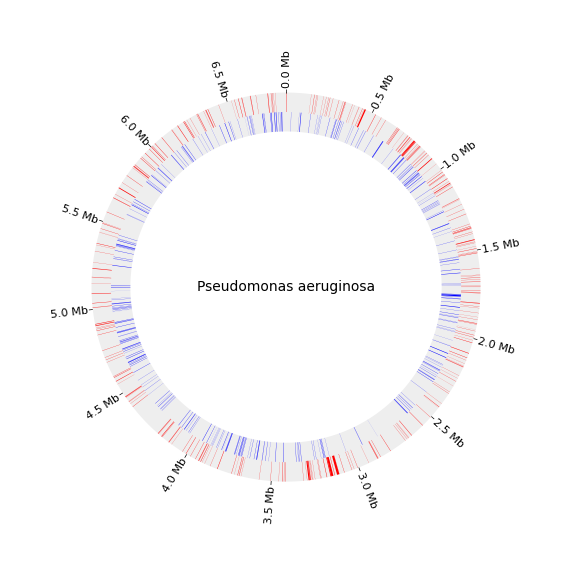

In [33]:
circos = Circos(sectors={accession: genome_length})
circos.text("Streptomyces coelicolor")
circos_gff = Gff(gff_file="candidates.gff")
sector = circos.get_sector(accession)
sector = circos.sectors[0]
cds_track = sector.add_track((80, 100))
cds_track.axis(fc="#EEEEEE", ec="none")
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand =  1), r_lim=(90, 100),fc="red" )
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand = -1), r_lim=(80,  90),fc="blue")
pos_list, labels = [], []
cds_track.xticks_by_interval(
    interval=500000,
    label_formatter=lambda label_value: f"{label_value/ 1000000:.1f} Mb",
    label_orientation="vertical")
fig = circos.plotfig().set_figwidth(5)

# 7. Examinación a detalle del genes seleccionados

Los genomas procarióticos están usualmente organizados en unidades operacionales llamadas operones, en donde los genes se encuentran muy proximos entre sí y en la misma cadena de DNA. Sin embargo, en la resistencia a antibioticos se sabe que se relacionan con elementos genéticos móviles, como plásmidos, transposones e integrones. Por lo que en este caso no se buscará un operón en especifico pero si los genes que se encuentran relacionados con la resistencia. 

In [35]:
operon_df = gff_df.copy()
operon_df = operon_df[(operon_df["start"]     >= 3000000) &
                      (operon_df["end"]       <= 3500000) &
                      (operon_df["strand"]    == "-")     &
                      (operon_df["candidate"] == "include")]
operon_df.reset_index(drop=True, inplace=True)

In [36]:
len(operon_df)

17

In [37]:
operon_gene_list = []
for index in operon_df.index.tolist():
    gene_id = operon_df["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)

In [38]:
operon_gene_list

['Scoe_2865',
 'Scoe_2934',
 'Scoe_2944',
 'Scoe_2948',
 'Scoe_2951',
 'Scoe_2965',
 'Scoe_2992',
 'Scoe_3001',
 'Scoe_3070',
 'Scoe_3079',
 'Scoe_3083',
 'Scoe_3087',
 'Scoe_3100',
 'Scoe_3101',
 'Scoe_3179',
 'Scoe_3180',
 'Scoe_3231']

Posteriormente, construiremos un string que contendrá las secuencias aminoacídicas de los genes de interés en formato fasta. 

Este string lo enviaremos al servicio web de InterProScan para buscar dominios conservados en nuestras proteínas. Eliminando los astericos de las secuencias. 


In [39]:
query_str = ""

In [40]:
for record in SeqIO.parse(aa_file, "fasta"):
    seq_id  = record.id
    if(seq_id in operon_gene_list):
        seq_str = str(record.seq)
        query_str+=">"+seq_id+"\n"+seq_str+"\n"
query_str = query_str.replace("*","")

El proceso de búsqueda de dominios lo dividiremos en tres etapas:


*   Envío de las secuencias
*   Consulta del status del envío
*   Descarga de resultados

Cada etapa tiene una URL específica la cual definiremos a continuación

In [41]:
submit_url   = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/run"
progress_url = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/status"
results_url  = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result"

In [42]:
submit_headers   = {"Accept":"text/plain"}
progress_headers = {"Accept":"text/plain"}
results_headers  = {"Accept":"text/tab-separated-values"}

Se construyo un diccionario de python que se adjunto a requests para buscar los dominios funcionales.

In [43]:
submit_data = {"email":"esmemarcela@gmail.com",
               "title":"operon_591_733",
               "goterms":"false",
               "pathways":"false",
               "stype":"p",
               "sequence":query_str}

In [44]:
submit_request = requests.post(submit_url,data=submit_data,headers=submit_headers)

La API de InterProScan entrega un código de estado y un job_id.
> El código de salida del servidor web, nos indican si la solicitud fue exitosa:
>>*   1xx informational response – the request was received, continuing process
*     2xx successful – the request was successfully received, understood, and accepted
*     3xx redirection – further action needs to be taken in order to complete the request
*     4xx client error – the request contains bad syntax or cannot be fulfilled
5xx server error – the server failed to fulfil an apparently valid request

In [45]:
submit_status_code = submit_request.status_code
submit_job_id      = submit_request.text

In [ ]:
print(submit_status_code)
print(submit_job_id)

In [ ]:
progress_request     = requests.get(progress_url+"/"+submit_job_id,headers=progress_headers)
progress_status_code = progress_request.status_code
progress_status      = progress_request.text
print(progress_status_code)
print(progress_status)


Si se obtiene 200 la consulta fue exitosa. 

In [ ]:
results_log_request = requests.get(results_url+"/"+submit_job_id+"/log",headers=results_headers)
results_tsv_request = requests.get(results_url+"/"+submit_job_id+"/tsv",headers=results_headers)

In [ ]:
print(results_log_request.text)

In [ ]:
results_tsv_str = StringIO(results_tsv_request.text)
results_column_names = ["sequence","md5","length","database","accession","description","start","end","evalue","post_processed","date","entry","name"]
results_df = pd.read_csv(results_tsv_str,sep="\t",names=results_column_names)
results_df